# Variational Autoencoders (VAEs)

## 🎯 Motivation: Image Generation

We want to build a model that can **generate realistic images** — like cats, digits, or landscapes.

Formally, this means sampling from some unknown data distribution:

$$
x \sim p(x)
$$

But the true distribution $p(x)$ over images is **unknown and highly complex**. So we want to **learn an approximate model** that can:

- Learn the structure of the data
- Generate new, realistic samples

---

## 🧠 Latent Variable Models

Instead of modeling $p(x)$ directly, we assume there's an **unobserved latent variable** $z$ that generates $x$.

We define a **generative model**:

$$
p_\theta(x, z) = p_\theta(x \mid z) \, p(z)
$$

- $p(z)$ is the **prior** over latent variables (usually standard normal)
- $p_\theta(x \mid z)$ is the **likelihood** or **decoder**, implemented as a neural network

The marginal likelihood is:

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

This model can **generate new images** by:

1. Sampling $z \sim p(z)$  
2. Computing $x \sim p_\theta(x \mid z)$

---

## 🚧 Intractability: Why Not Just Maximize $\log p(x)$?

The integral

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

is often **intractable**, because:

- $p_\theta(x \mid z)$ is defined by a neural net (not analytically integrable)
- $z$ is high-dimensional

This also makes the **posterior** $p(z \mid x)$ intractable:

$$
p(z \mid x) = \frac{p_\theta(x \mid z) p(z)}{p_\theta(x)}
$$

So we can't use exact maximum likelihood.

---

## 💡 Variational Inference

In latent variable models like VAEs, we define a joint distribution:

$$
p_\theta(x, z) = p_\theta(x \mid z) \, p(z)
$$

To compute the data likelihood, we marginalize over the latent variable:

$$
\log p_\theta(x) = \log \int p_\theta(x, z) \, dz
$$

This integral is typically intractable, so we apply **importance sampling** using an approximate posterior $q_\phi(z \mid x)$:

$$
\log p_\theta(x) 
= \log \int \frac{q_\phi(z \mid x)}{q_\phi(z \mid x)} \, p_\theta(x, z) \, dz
= \log \mathbb{E}_{q_\phi(z \mid x)} \left[ \frac{p_\theta(x, z)}{q_\phi(z \mid x)} \right]
$$

By **Jensen’s inequality**, we lower-bound the log of this expectation:

$$
\log p_\theta(x) 
\geq \mathbb{E}_{q_\phi(z \mid x)} \left[ \log \frac{p_\theta(x, z)}{q_\phi(z \mid x)} \right]
$$

This gives the **Evidence Lower Bound (ELBO)**:

$$
\log p_\theta(x) 
\geq 
\underbrace{
\mathbb{E}_{q_\phi(z \mid x)} \left[ \log p_\theta(x \mid z) \right]
}_{\text{Reconstruction term}} 
\;\; - \;\;
\underbrace{
D_{\text{KL}}\left( q_\phi(z \mid x) \,\|\, p(z) \right)
}_{\text{Regularization (KL) term}}
$$

- The **reconstruction term** encourages the decoder to explain the data well
- The **KL term** keeps the approximate posterior close to the prior

This ELBO is the objective we optimize when training VAEs.



---

## 🔧 VAE Loss Function

The variational objective we optimize is:

$$
\mathcal{L}_{\text{VAE}}(x) = - \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)] + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

This balances:

- How well the model **reconstructs** the input from latent $z$
- How close the learned posterior is to the **prior**

## 🔁 Reparameterization Trick

To train the encoder using gradient descent, we need to compute gradients of the ELBO with respect to its parameters $\phi$:

$$
\nabla_\phi \; \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
$$

However, directly sampling from $q_\phi(z \mid x)$ — which is a learned Gaussian — breaks the computation graph, because sampling is a non-differentiable operation.

We assume the encoder outputs a **diagonal Gaussian posterior**:

$$
q_\phi(z \mid x) = \mathcal{N}(z; \mu_\phi(x), \text{diag}(\sigma^2_\phi(x)))
$$

To enable gradient flow, we apply the **reparameterization trick**. Instead of sampling $z$ directly from $q_\phi(z \mid x)$, we:

1. Sample noise from a standard normal: $\epsilon \sim \mathcal{N}(0, I)$  
2. Transform it using the encoder outputs:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon
$$

This transforms the stochastic operation into a **deterministic and differentiable function** of $\phi$, while keeping the randomness external via $\epsilon$.

Now, the expectation becomes:

$$
\mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \log p_\theta(x \mid \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon) \right]
$$

This version is differentiable with respect to $\phi$, so we can use standard gradient-based optimization to train the encoder.

---

## 📏 KL Divergence as a Regularizer

We use a standard normal prior:

$$
p(z) = \mathcal{N}(0, I)
$$

The KL divergence between $q_\phi(z \mid x)$ and $p(z)$ can be computed in closed form:

$$
D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z)) = \frac{1}{2} \sum_{j=1}^{d} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right)
$$

This term encourages the latent space to stay close to the prior — it acts as a **regularizer**.

---


## 🧪 Monte Carlo Estimation of the ELBO

The expectation in the reconstruction term of the ELBO:

$$
\mathbb{E}_{q_\phi(z \mid x)} \left[ \log p_\theta(x \mid z) \right]
$$

is typically estimated using **a single sample** $z^{(1)} \sim q_\phi(z \mid x)$ from the encoder:

$$
\log p_\theta(x \mid z) \approx \log p_\theta(x \mid z^{(1)})
$$

So the final training loss becomes:

$$
\mathcal{L}(x) \approx - \log p_\theta(x \mid z^{(1)}) + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

The form of the **log-likelihood** term $\log p_\theta(x \mid z)$ depends on the assumed likelihood distribution.

---

### 📘 Case 1: Bernoulli Likelihood

If we assume each pixel $x_i$ is a Bernoulli random variable:

$$
p_\theta(x \mid z) = \prod_{i=1}^D \text{Bernoulli}(x_i; \hat{x}_i)
$$

Where $\hat{x}_i \in [0, 1]$ is the decoder's output (after sigmoid activation). Then:

$$
\log p_\theta(x \mid z) = \sum_{i=1}^D \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
$$

This is the **binary cross-entropy (BCE)** loss.

---

### 📘 Case 2: Gaussian Likelihood

If we assume each pixel $x_i$ is drawn from a Gaussian with fixed unit variance:

$$
p_\theta(x \mid z) = \mathcal{N}(x; \hat{x}, I)
$$

Then the log-likelihood is:

$$
\log p_\theta(x \mid z) = -\frac{1}{2} \|x - \hat{x}\|^2 + \text{const}
$$

Maximizing the log-likelihood is equivalent to **minimizing the mean squared error (MSE)** between $x$ and $\hat{x}$.

---

In both cases, the reconstruction loss corresponds to the **negative log-likelihood** under the chosen decoder distribution.

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

### Code example for Bernoulli and Gaussian likelihood

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Encoder: x -> z (mean and logvar)
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# Decoder: z -> x_hat
class Decoder(nn.Module):
    def __init__(
        self, latent_dim=20, hidden_dim=400, output_dim=784, likelihood="bernoulli"
    ):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.likelihood = likelihood

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = self.fc_out(h)
        if self.likelihood == "bernoulli":
            return torch.sigmoid(out)  # probability of pixel being white
        else:  # "gaussian"
            return out  # raw output; assume Gaussian mean


class VAE(nn.Module):
    def __init__(
        self, input_dim=784, hidden_dim=400, latent_dim=20, likelihood="bernoulli"
    ):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, likelihood)
        self.likelihood = likelihood

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


def vae_loss(x, x_hat, mu, logvar, likelihood="bernoulli"):
    if likelihood == "bernoulli":
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    elif likelihood == "gaussian":
        recon_loss = F.mse_loss(x_hat, x, reduction="sum")
    else:
        raise ValueError(f"Unknown likelihood type: {likelihood}")

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


def run_training(likelihood: str, epochs: int = 100, show_every: int = 10):

    transform = transforms.ToTensor()
    train_loader = DataLoader(
        datasets.MNIST(root="./data", train=True, download=True, transform=transform),
        batch_size=1024,
        shuffle=True,
    )

    # Initialize model, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vae = VAE(likelihood=likelihood).to(device)
    optimizer = torch.optim.Adam(vae.parameters())

    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for x, _ in train_loader:
            x = x.view(-1, 784).to(device)
            x_hat, mu, logvar = vae(x)

            loss = vae_loss(x, x_hat, mu, logvar, likelihood)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            vae.eval()
            with torch.no_grad():
                z = torch.randn(16, 20).to(device)
                samples = vae.decoder(z)
                samples = samples.cpu().view(-1, 1, 28, 28)
                grid = torchvision.utils.make_grid(samples, nrow=4)
                plt.figure(figsize=(4, 4))
                plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
                plt.title(f"Generated Samples (Epoch {epoch+1})")
                plt.axis("off")
                plt.show()

Epoch 1, Loss: 260.0992
Epoch 2, Loss: 184.2270
Epoch 3, Loss: 156.4301
Epoch 4, Loss: 142.9219
Epoch 5, Loss: 134.3718
Epoch 6, Loss: 128.5569
Epoch 7, Loss: 124.6136
Epoch 8, Loss: 121.4010
Epoch 9, Loss: 119.0274
Epoch 10, Loss: 117.2130


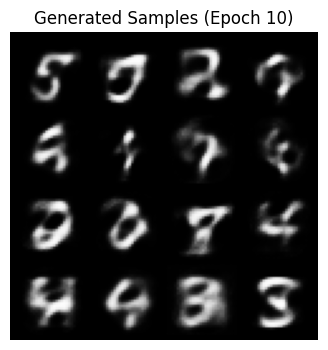

Epoch 11, Loss: 115.7321
Epoch 12, Loss: 114.5964
Epoch 13, Loss: 113.6707
Epoch 14, Loss: 112.8307
Epoch 15, Loss: 112.1785
Epoch 16, Loss: 111.5226
Epoch 17, Loss: 110.9520
Epoch 18, Loss: 110.4405
Epoch 19, Loss: 109.9624
Epoch 20, Loss: 109.5862


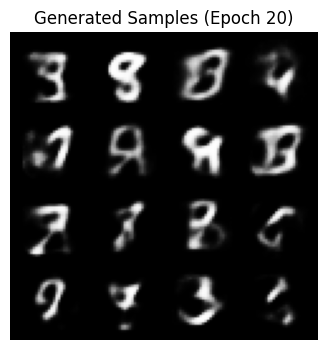

Epoch 21, Loss: 109.2409
Epoch 22, Loss: 108.8817
Epoch 23, Loss: 108.5950
Epoch 24, Loss: 108.3532
Epoch 25, Loss: 108.0640
Epoch 26, Loss: 107.8517
Epoch 27, Loss: 107.6011
Epoch 28, Loss: 107.3888
Epoch 29, Loss: 107.1667
Epoch 30, Loss: 106.9226


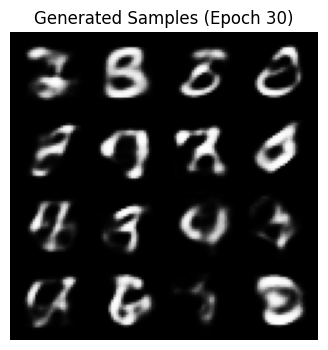

Epoch 31, Loss: 106.7693
Epoch 32, Loss: 106.6205
Epoch 33, Loss: 106.4851
Epoch 34, Loss: 106.2790
Epoch 35, Loss: 106.1164
Epoch 36, Loss: 106.0097
Epoch 37, Loss: 105.8882
Epoch 38, Loss: 105.7221
Epoch 39, Loss: 105.6948
Epoch 40, Loss: 105.5299


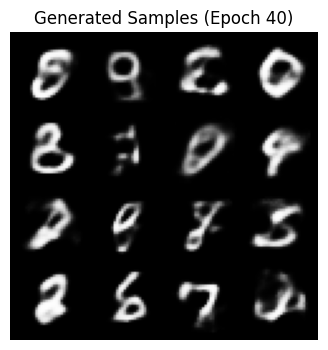

Epoch 41, Loss: 105.3669
Epoch 42, Loss: 105.3073
Epoch 43, Loss: 105.1712
Epoch 44, Loss: 105.0584
Epoch 45, Loss: 104.9973
Epoch 46, Loss: 104.9173
Epoch 47, Loss: 104.8085
Epoch 48, Loss: 104.7787
Epoch 49, Loss: 104.5548
Epoch 50, Loss: 104.5618


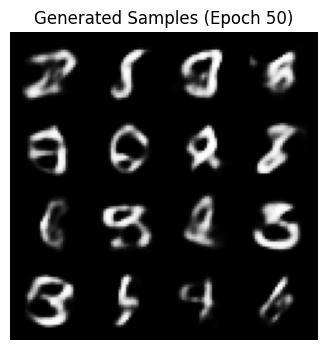

Epoch 51, Loss: 104.4933
Epoch 52, Loss: 104.4756
Epoch 53, Loss: 104.3861
Epoch 54, Loss: 104.2516
Epoch 55, Loss: 104.2263
Epoch 56, Loss: 104.1155
Epoch 57, Loss: 104.0796
Epoch 58, Loss: 103.9780
Epoch 59, Loss: 103.9090
Epoch 60, Loss: 103.8736


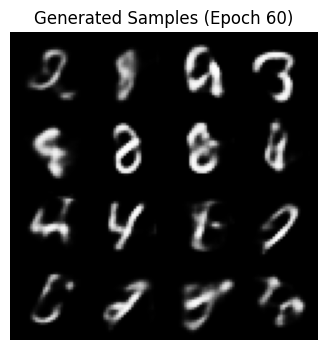

Epoch 61, Loss: 103.8150
Epoch 62, Loss: 103.7383
Epoch 63, Loss: 103.7320
Epoch 64, Loss: 103.6129
Epoch 65, Loss: 103.6014
Epoch 66, Loss: 103.5312
Epoch 67, Loss: 103.5155
Epoch 68, Loss: 103.4560
Epoch 69, Loss: 103.4002
Epoch 70, Loss: 103.3245


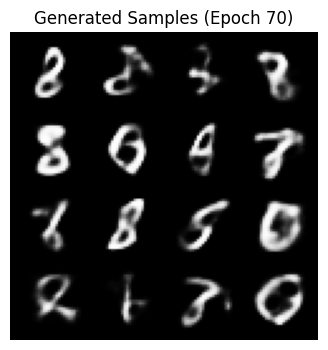

Epoch 71, Loss: 103.3017
Epoch 72, Loss: 103.2266
Epoch 73, Loss: 103.1904
Epoch 74, Loss: 103.1868
Epoch 75, Loss: 103.1458
Epoch 76, Loss: 103.0791
Epoch 77, Loss: 103.0620
Epoch 78, Loss: 103.0050
Epoch 79, Loss: 102.9607
Epoch 80, Loss: 102.8782


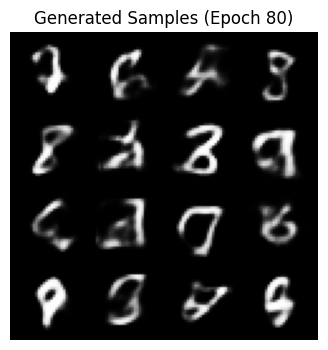

Epoch 81, Loss: 102.8748
Epoch 82, Loss: 102.8233
Epoch 83, Loss: 102.7772
Epoch 84, Loss: 102.7675
Epoch 85, Loss: 102.6737
Epoch 86, Loss: 102.6571
Epoch 87, Loss: 102.7226
Epoch 88, Loss: 102.5856
Epoch 89, Loss: 102.5779
Epoch 90, Loss: 102.5595


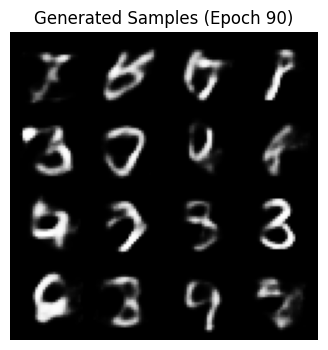

Epoch 91, Loss: 102.5570
Epoch 92, Loss: 102.5106
Epoch 93, Loss: 102.4029
Epoch 94, Loss: 102.4173
Epoch 95, Loss: 102.3894
Epoch 96, Loss: 102.3317
Epoch 97, Loss: 102.3009
Epoch 98, Loss: 102.2686
Epoch 99, Loss: 102.2527
Epoch 100, Loss: 102.2614


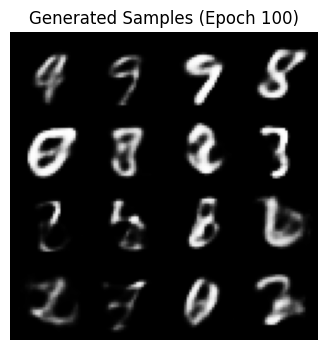

In [2]:
run_training("bernoulli", epochs=100)

Epoch 1, Loss: 60.2823
Epoch 2, Loss: 43.3187
Epoch 3, Loss: 39.3796
Epoch 4, Loss: 37.4287
Epoch 5, Loss: 36.2366
Epoch 6, Loss: 35.5114
Epoch 7, Loss: 35.0078
Epoch 8, Loss: 34.6127
Epoch 9, Loss: 34.3364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3917101..1.4782248].


Epoch 10, Loss: 34.0550


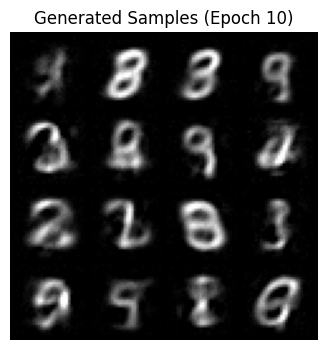

Epoch 11, Loss: 33.8867
Epoch 12, Loss: 33.7161
Epoch 13, Loss: 33.5493
Epoch 14, Loss: 33.3653
Epoch 15, Loss: 33.2535
Epoch 16, Loss: 33.0978
Epoch 17, Loss: 33.0022
Epoch 18, Loss: 32.8445
Epoch 19, Loss: 32.7561


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48812732..1.7158508].


Epoch 20, Loss: 32.6479


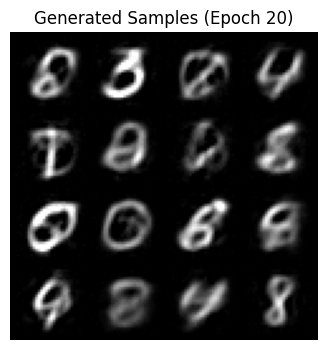

Epoch 21, Loss: 32.5624
Epoch 22, Loss: 32.4448
Epoch 23, Loss: 32.3407
Epoch 24, Loss: 32.2684
Epoch 25, Loss: 32.1935
Epoch 26, Loss: 32.1019
Epoch 27, Loss: 32.0009
Epoch 28, Loss: 31.9029
Epoch 29, Loss: 31.8526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3558384..1.308885].


Epoch 30, Loss: 31.8010


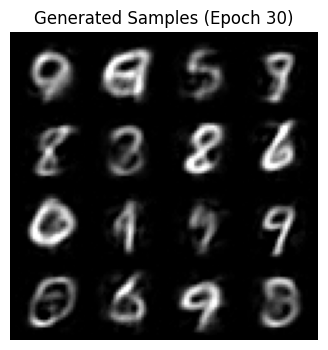

Epoch 31, Loss: 31.7318
Epoch 32, Loss: 31.6844
Epoch 33, Loss: 31.6162
Epoch 34, Loss: 31.5588
Epoch 35, Loss: 31.5206
Epoch 36, Loss: 31.4436
Epoch 37, Loss: 31.4265
Epoch 38, Loss: 31.3913
Epoch 39, Loss: 31.3332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61115557..1.6123827].


Epoch 40, Loss: 31.3053


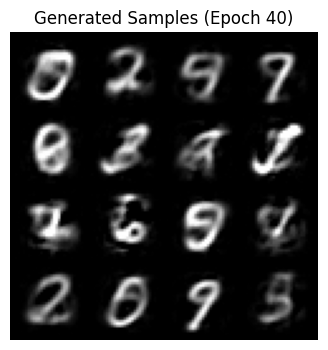

Epoch 41, Loss: 31.2544
Epoch 42, Loss: 31.2348
Epoch 43, Loss: 31.1881
Epoch 44, Loss: 31.1522
Epoch 45, Loss: 31.1153
Epoch 46, Loss: 31.0804
Epoch 47, Loss: 31.0628
Epoch 48, Loss: 30.9940
Epoch 49, Loss: 30.9934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2812674..1.4431604].


Epoch 50, Loss: 30.9739


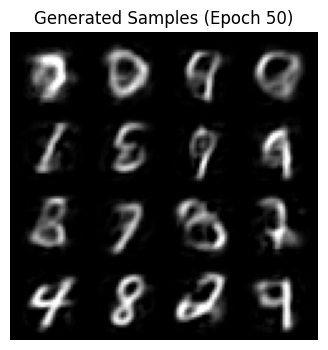

Epoch 51, Loss: 30.9207
Epoch 52, Loss: 30.9446
Epoch 53, Loss: 30.8753
Epoch 54, Loss: 30.8616
Epoch 55, Loss: 30.8463
Epoch 56, Loss: 30.8095
Epoch 57, Loss: 30.8135
Epoch 58, Loss: 30.7912
Epoch 59, Loss: 30.7507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30924642..1.4699641].


Epoch 60, Loss: 30.7332


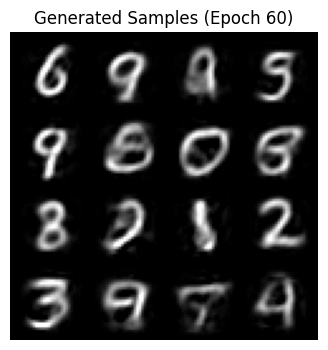

Epoch 61, Loss: 30.7205
Epoch 62, Loss: 30.6901
Epoch 63, Loss: 30.6803
Epoch 64, Loss: 30.6474
Epoch 65, Loss: 30.6328
Epoch 66, Loss: 30.6103
Epoch 67, Loss: 30.5773
Epoch 68, Loss: 30.6004
Epoch 69, Loss: 30.5505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42606878..1.2813706].


Epoch 70, Loss: 30.5522


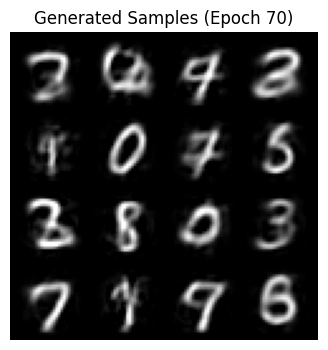

Epoch 71, Loss: 30.5091
Epoch 72, Loss: 30.5309
Epoch 73, Loss: 30.4892
Epoch 74, Loss: 30.4587
Epoch 75, Loss: 30.4730
Epoch 76, Loss: 30.4441
Epoch 77, Loss: 30.4222
Epoch 78, Loss: 30.4290
Epoch 79, Loss: 30.4062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61069256..1.6393803].


Epoch 80, Loss: 30.3695


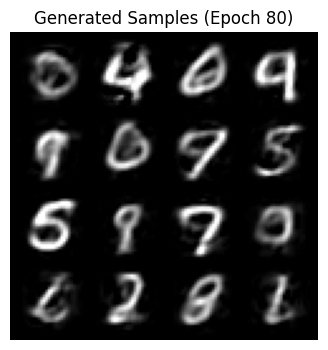

Epoch 81, Loss: 30.3575
Epoch 82, Loss: 30.3389
Epoch 83, Loss: 30.3290
Epoch 84, Loss: 30.3595
Epoch 85, Loss: 30.3216
Epoch 86, Loss: 30.3035
Epoch 87, Loss: 30.2616
Epoch 88, Loss: 30.2525
Epoch 89, Loss: 30.2554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35406506..1.2773954].


Epoch 90, Loss: 30.2399


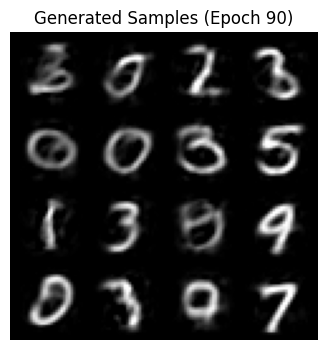

Epoch 91, Loss: 30.2311
Epoch 92, Loss: 30.2197
Epoch 93, Loss: 30.2136
Epoch 94, Loss: 30.1663
Epoch 95, Loss: 30.1602
Epoch 96, Loss: 30.1612
Epoch 97, Loss: 30.1578
Epoch 98, Loss: 30.1474
Epoch 99, Loss: 30.1286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42133564..1.8606042].


Epoch 100, Loss: 30.1297


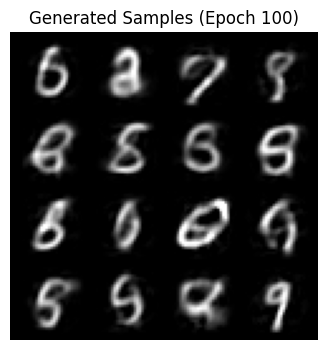

In [3]:
run_training("gaussian", epochs=100)

You can see that when the likelihood is modeled as a Gaussian, the generated images tend to be blurrier compared to those produced using a Bernoulli likelihood. This difference becomes clearer when you consider the loss functions involved—MSE versus BCE. While both losses encourage the predictions to match the target values, BCE tends to push the outputs more aggressively toward the extremes (closer to 0 or 1). In contrast, MSE, consistent with the Gaussian assumption, doesn't penalize small deviations as strongly, resulting in smoother, often blurrier reconstructions.